In [11]:
# dataframe and array
import pandas as pd
import numpy as np

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# sklearn
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve,accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# for hyperopt
from hyperopt import tpe
from hpsklearn import HyperoptEstimator, any_classifier

# for sampling
from imblearn.over_sampling import SMOTE


### the dataset

In [2]:
data = pd.read_csv("D://datasource/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 对其他变量不做过多处理
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

C:\Users\lakala\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### sampling

In [4]:
from __future__ import division
# =================================================全量

X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']
# Showing ratio
print ('For whole dataset')
print("Percentage of normal transactions: ", len(data[data.Class == 0])/len(data))
print("Percentage of fraud transactions: ", len(data[data.Class == 1])/len(data))
print("Total number of transactions in data: ", len(data))

# train test split for whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=886)

# =================================================欠抽样
# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# train test split for undersample dataset
X_train_usample, X_test_usample, y_train_usample, y_test_usample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=886)

# Showing ratio
print ('For undersample')
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))


# =================================================SMOTE
oversampler = SMOTE(random_state=0)
X_oversample, y_oversample = oversampler.fit_sample(X, y)

# back to df
X_oversample = pd.DataFrame(X_oversample, columns=X.columns)
y_oversample = pd.DataFrame(y_oversample, columns=y.columns)

# train test split for undersample dataset
X_train_osample, X_test_osample, y_train_osample, y_test_osample = train_test_split(X_oversample, y_oversample, test_size=0.3, random_state=886)


# Showing ratio
print ('\nFor oversample')
print("Percentage of normal transactions: ", len(y_oversample[y_oversample.Class == 0])/len(y_oversample))
print("Percentage of fraud transactions: ", len(y_oversample[y_oversample.Class == 1])/len(y_oversample))
print("Total number of transactions in resampled data: ", len(y_oversample))

For whole dataset
('Percentage of normal transactions: ', 0.9982725143693799)
('Percentage of fraud transactions: ', 0.001727485630620034)
('Total number of transactions in data: ', 284807)
For undersample
('Percentage of normal transactions: ', 0.5)
('Percentage of fraud transactions: ', 0.5)
('Total number of transactions in resampled data: ', 984)


C:\Users\lakala\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



For oversample
('Percentage of normal transactions: ', 0.5)
('Percentage of fraud transactions: ', 0.5)
('Total number of transactions in resampled data: ', 568630)


### model selection 

In [5]:
# load the testing dataset
from sklearn.datasets import load_iris
iris = load_iris()

In [6]:
# cross_val_score
clf = RandomForestClassifier()
cross_val_score(clf, iris.data, iris.target, cv=5) #5-fold cv

# 5折fold
# 默认输出score为准确率

array([ 0.96666667,  0.96666667,  0.96666667,  0.93333333,  1.        ])

In [7]:
# 直接使用dataframe作为输入
# 不接受dataframe直接输入
cross_val_score(clf, X.values, y.Class, cv=5) #5-fold cv

array([ 0.99903444,  0.99947333,  0.99915732,  0.99954355,  0.99947332])

In [12]:
# 可以用其他分数 如f1， auc
cross_val_score(clf, X, y.Class, cv=5, scoring='f1')

array([ 0.74439462,  0.85057471,  0.73743017,  0.82840237,  0.8       ])

In [8]:
# 扩展同时支持多个分数输出

from multiscorer import MultiScorer  #https://github.com/StKyr/multiscorer/
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [19]:
models = [GaussianNB(), DecisionTreeClassifier(), SVC(), RandomForestClassifier()]
names = ["Naive Bayes", "Decision Tree", "SVM", "RF"]

scorer = MultiScorer({
    'Accuracy' : (accuracy_score, {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall' : (recall_score, {'pos_label': 3, 'average':'macro'}),
    'F1' : (f1_score, {'pos_label': 3, 'average':'macro'})  # 因为目标是三个类，不能用默认值
})

for model, name in zip(models, names):
    print name
    start = time.time()

    cross_val_score(model, iris.data, iris.target,scoring=scorer, cv=10)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        scores = np.array(results[metric_name])
        print("%s: %0.5f (+/- %0.3f)" % (metric_name, scores.mean(), scores.std() * 2))
#         print('%s : %f' % (metric_name, average_score))

    print 'time', time.time() - start, '\n\n'

Naive Bayes
Recall: 0.95333 (+/- 0.085)
Accuracy: 0.95333 (+/- 0.085)
Precision: 0.96270 (+/- 0.065)
F1: 0.95244 (+/- 0.088)
time 0.058000087738 


Decision Tree
Recall: 0.95333 (+/- 0.085)
Accuracy: 0.95333 (+/- 0.085)
Precision: 0.96079 (+/- 0.073)
F1: 0.95272 (+/- 0.087)
time 0.050999879837 


SVM
Recall: 0.96222 (+/- 0.082)
Accuracy: 0.96222 (+/- 0.082)
Precision: 0.96831 (+/- 0.070)
F1: 0.96175 (+/- 0.083)
time 0.0570001602173 


RF
Recall: 0.96333 (+/- 0.079)
Accuracy: 0.96333 (+/- 0.079)
Precision: 0.96929 (+/- 0.067)
F1: 0.96289 (+/- 0.080)
time 0.694999933243 




In [20]:
# 比较不同的抽样
print "全抽样"
for model, name in zip(models, names):
    print name
    start = time.time()

    cross_val_score(model, X, y.Class,scoring=scorer, cv=10)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        scores = np.array(results[metric_name])
        print("%s: %0.5f (+/- %0.3f)" % (metric_name, scores.mean(), scores.std() * 2))
#         print('%s : %f' % (metric_name, average_score))

    print 'time', time.time() - start, '\n\n'


全抽样
Naive Bayes
Recall: 0.95135 (+/- 0.095)
Accuracy: 0.96620 (+/- 0.071)
Precision: 0.88153 (+/- 0.356)
F1: 0.88060 (+/- 0.337)
time 4.77699995041 


Decision Tree
Recall: 0.93432 (+/- 0.123)
Accuracy: 0.97160 (+/- 0.069)
Precision: 0.87293 (+/- 0.335)
F1: 0.87226 (+/- 0.315)
time 333.355999947 


SVM
Recall: 0.90698 (+/- 0.187)
Accuracy: 0.97552 (+/- 0.067)
Precision: 0.88239 (+/- 0.318)
F1: 0.86239 (+/- 0.302)
time 6352.273 


RF
Recall: 0.90108 (+/- 0.186)
Accuracy: 0.97849 (+/- 0.065)
Precision: 0.89065 (+/- 0.304)
F1: 0.86590 (+/- 0.286)
time 399.816999912 




### 单变量分析

In [17]:
# 对于联系变量倾向于使用柱状和密度图查看区别，另外就是箱图
# Histograms
def showHist(df, columns):
    '''
    columns is the cols you want to check;
    df is the source df;
    '''
    plt.figure(figsize=(18, len(columns) * 5))  # 全图大小
    gs = gridspec.GridSpec(len(columns), 1)     # 网格
    for i, col in enumerate(df.loc[:, columns]):
        ax = plt.subplot(gs[i])   # 分图在网格中的位置
        sns.distplot(df[col][df.Class == 1], bins=50, label='Fraud', color='tomato')
        sns.distplot(df[col][df.Class == 0], bins=50, label='Normal', color='teal')
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(col))
        plt.legend(loc='best')

    plt.show()


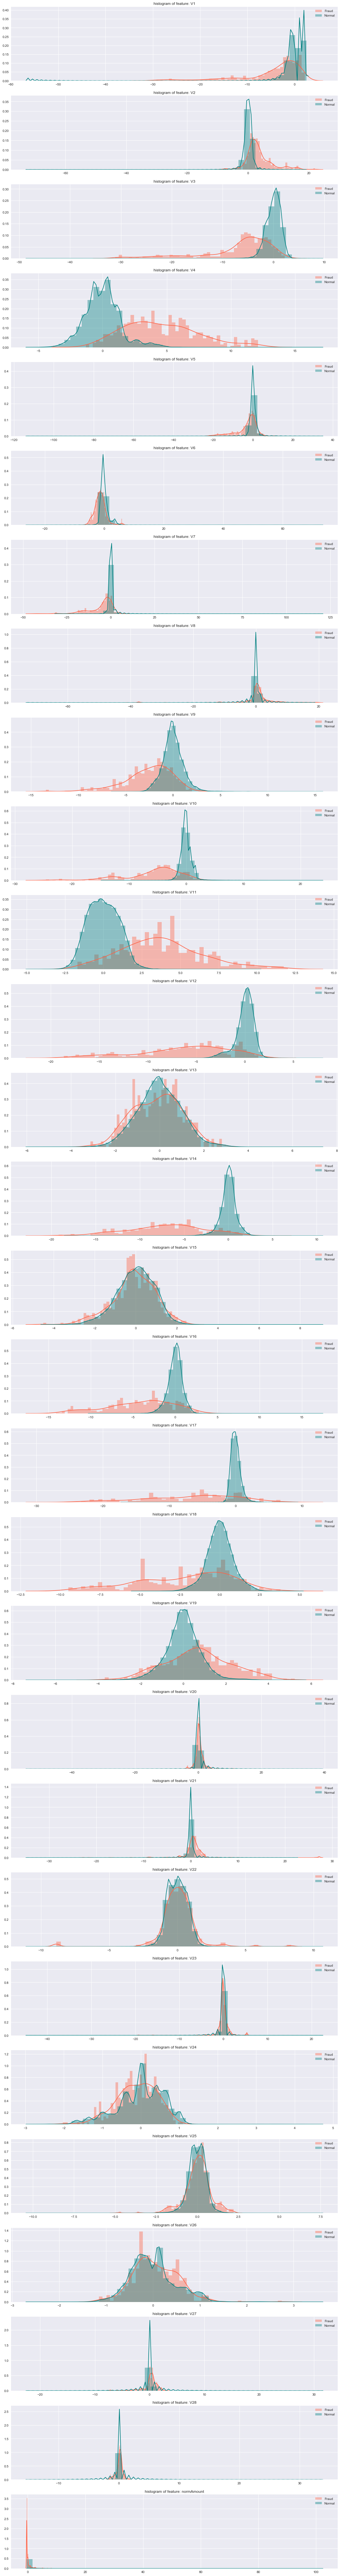

In [18]:
his_cols = list(data.columns)
his_cols.remove('Class')  # remove the Y
showHist(data, his_cols)

In [19]:
def showBox(df, columns):
    '''
    columns is the cols you want to check;
    df is the source df;
    '''
    plt.figure(figsize=(18, len(columns) * 5))  # 全图大小
    gs = gridspec.GridSpec(len(columns), 1)     # 网格
    for i, col in enumerate(df.loc[:, columns]):
        ax = plt.subplot(gs[i])   # 分图在网格中的位置
#         sns.distplot(data[col][data.Class == 1], bins=50, label='Fraud', color='tomato')
#         sns.distplot(data[col][data.Class == 0], bins=50, label='Normal', color='teal')
        sns.boxplot(x=col, y='Class', data=df)
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(col))
        plt.legend(loc='best')

    plt.show()

In [ ]:
his_cols = list(data.columns)
his_cols.remove('Class')  # remove the Y
showBox(data, his_cols)